In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdm.src.fdm3t import fdm3t, Fdm3t
from fdm.src.mfgrid import Grid
from scipy.special import exp1
import etc

Wh(0.001, 0.3)  = (2.7449201210813685, 4.580772753804319e-09)
Wh(0.01, 0.3)   = (2.7104287908047175, 1.8261895390546826e-09)
Wh(0.1, 0.3)    = (1.6703650224009043, 5.50906758939597e-09)


In [2]:
dtypeQ   = np.dtype([('I', np.int32), ('q', float)])
dtypeH   = np.dtype([('I', np.int32), ('h', float)])
dtypeGHB = np.dtype([('I', np.int32), ('h', float), ('C', float)])

In [3]:
def theis1(um1=None, r=None, D=None, kr=None, kz=None, ss=None, r_=None, epsilon=0.67, **kw):
    """Return Theis output in a one-layer axially symmetric model.

    If np.all(ss == 0.), steady state should be returned. For his at least
    one cell must be fixed head (as specified by fh).
    """

    kD = (kr * D).sum()
    S  = (ss * D).sum()

    z = -np.cumsum(np.hstack((0, D)))
    gr = Grid(r, [-0.5, 0.5], z, axial=True)
    idomain = gr.const(1, dtype=int)

    Q = 4 * np.pi * kD

    ir = np.arange(gr.nx + 1)[r < 60][-1]
    t = um1 * r[ir] ** 2 * S / (4 * kD)

    hi = gr.const(0.)
    hi[0, 0, :] = Q / (4 * np.pi * kD) * exp1(gr.xm ** 2 * D  / (4 * kD * t[0]))

    fq = np.zeros(1, dtype=dtypeQ)
    fq['I'], fq['q'] = gr.NOD[-1, 0, 0], Q
    fq = {0: fq}


    fh = np.zeros(gr.nz * gr.ny, dtype=dtypeH)
    fh['I'], fh['h'] = gr.NOD[:, :, -1].ravel(), 0
    fh = {0: fh}
    fh = None

    out = fdm3t(gr=gr, t=t, k=(kr, kr, kz), ss=ss, fh=fh, fq=fq, hi=hi, idomain=idomain, epsilon=epsilon)

    xlim = np.logspace(-2, 6, 2)
    ylim = np.logspace(-4, 1, 2)

    ax = etc.newfig(kw['title'],
        'r increases <---- (4 kD / S) t / r^2 [-] ----> time increase' ,
        's / (Q / (4 pi kD)) [-]',
        xscale='log', yscale='log',
        xlim=xlim, ylim=ylim)

    cc = etc.color_cycler()
    # select a few distances for which the show the graph
    for ir in range(0, gr.nx, 10):
        color = next(cc)
        rm = gr.xm[ir]
        if rm < 1.0 or rm > 1000.:
            continue
        ax.plot((4 * kD  / S) * (t / rm ** 2), out['Phi'][:, -1, 0, ir] / (Q / (4 * np.pi * kD)), '-', color=color, label=f'r={gr.xm[ir]:.3g} m')

    ax.plot(um1, exp1(1 / um1), '.', label=f'Theis, r={gr.xm[ir]:.3g} m')
    ax.legend()
    return ax

def theis_use_class(um1=None, r=None, D=None, kr=None, kz=None, ss=None, r_=None, epsilon=0.67, **kw):
    """Return Theis output in a one-layer axially symmetric model, but use class Fdm3t instead of function fdm3t.

    If np.all(ss == 0.), steady state should be returned. For his at least
    one cell must be fixed head (as specified by fh).
    """

    kD = (kr * D).sum()
    S  = (ss * D).sum()

    z = -np.cumsum(np.hstack((0, D)))
    gr = Grid(r, [-0.5, 0.5], z, axial=True)
    idomain = gr.const(1, dtype=int)

    mdl = Fdm3t(gr=gr, k= (kr, kr, kz), c=None, ss=ss, idomain=idomain)

    Q = 4 * np.pi * kD

    ir = np.arange(gr.nx + 1)[r < 60][-1]
    t = um1 * r[ir] ** 2 * S / (4 * kD)

    hi = gr.const(0.)
    hi[0, 0, :] = Q / (4 * np.pi * kD) * exp1(gr.xm ** 2 * D  / (4 * kD * t[0]))

    fq = np.zeros(1, dtype=dtypeQ)
    fq['I'], fq['q'] = gr.NOD[-1, 0, 0], Q
    fq = {0: fq}


    fh = np.zeros(gr.nz * gr.ny, dtype=dtypeH)
    fh['I'], fh['h'] = gr.NOD[:, :, -1].ravel(), 0
    fh = {0: fh}
    fh = None

    out = mdl.simulate(t=t, fh=fh, fq=fq, hi=hi, epsilon=epsilon)

    xlim = np.logspace(-2, 6, 2)
    ylim = np.logspace(-4, 1, 2)

    ax = etc.newfig(kw['title'],
        'r increases <---- (4 kD / S) t / r^2 [-] ----> time increase' ,
        's / (Q / (4 pi kD)) [-]',
        xscale='log', yscale='log',
        xlim=xlim, ylim=ylim)

    cc = etc.color_cycler()
    # select a few distances for which the show the graph
    for ir in range(0, gr.nx, 10):
        color = next(cc)
        rm = gr.xm[ir]
        if rm < 1.0 or rm > 1000.:
            continue
        ax.plot((4 * kD  / S) * (t / rm ** 2), out['Phi'][:, -1, 0, ir] / (Q / (4 * np.pi * kD)), '-', color=color, label=f'r={gr.xm[ir]:.3g} m')

    ax.plot(um1, exp1(1 / um1), '.', label=f'Theis, r={gr.xm[ir]:.3g} m')
    ax.legend()
    return ax


In [4]:
theis_kwargs = {
        'title': r"""Theis numeric vs um1 = 1/u. Increasing um1 --> increasing time --> decreasing r.
         Curves for different r overlap due to the choice of both axes which yieldds the Theis type curve.
         Small deviations with the analytic type curve occur only for very large r or very small t.
         """,
         'comment': """Theis numeric.
         Computes the theis type curve by plotting s / (Q / (4 pi kD) vs 4 kD / S * t / r^2
         and compare this with the real theis function exp1.
         """,
        'um1': np.logspace(-5, 9, 141), # um1 = 1/ u
        'r': np.hstack((0., np.logspace(-2, 6, 381))),
        'D': np.array([50.]),
        'kr': np.array([10.]),
        'kz': np.array([1e6]),
        'ss': np.array([1e-5]),
        'epsilon': 0.5,
        }

Running in axial mode, y-values are ignored.
Axially symmetric model, y-values are ignored.
Running in axial mode, y-values are ignored.
Model was run, see self.out


<Axes: title={'center': 'Theis numeric vs um1 = 1/u. Increasing um1 --> increasing time --> decreasing r.\n         Curves for different r overlap due to the choice of both axes which yieldds the Theis type curve.\n         Small deviations with the analytic type curve occur only for very large r or very small t.\n         '}, xlabel='r increases <---- (4 kD / S) t / r^2 [-] ----> time increase', ylabel='s / (Q / (4 pi kD)) [-]'>

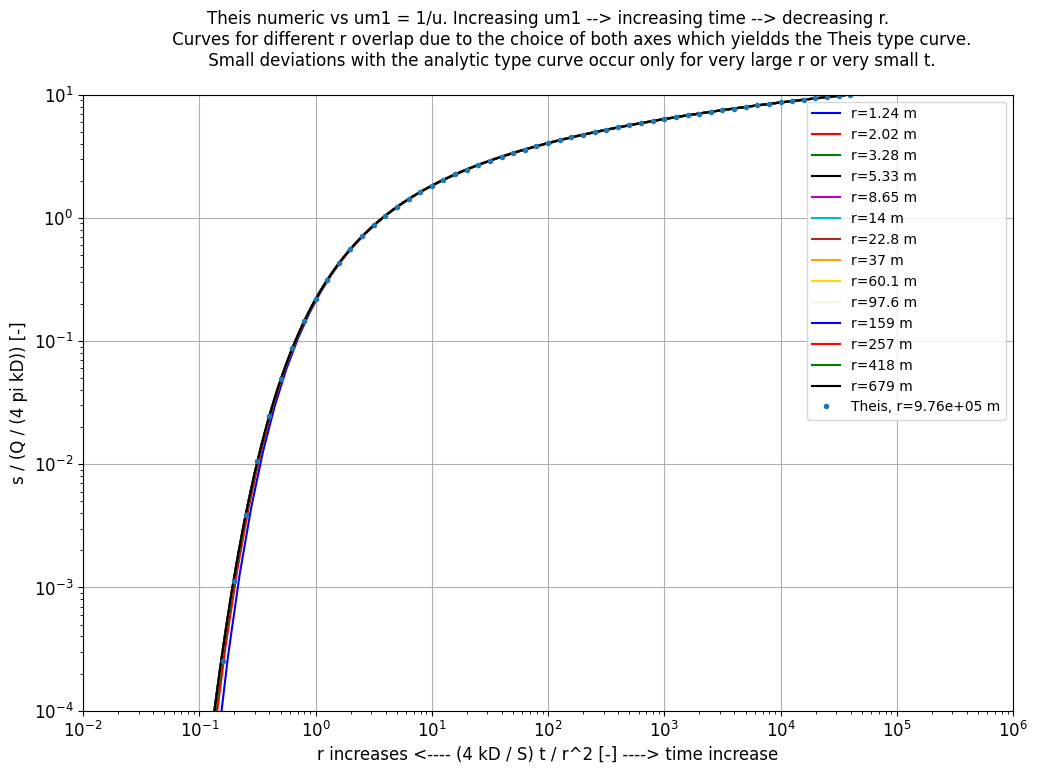

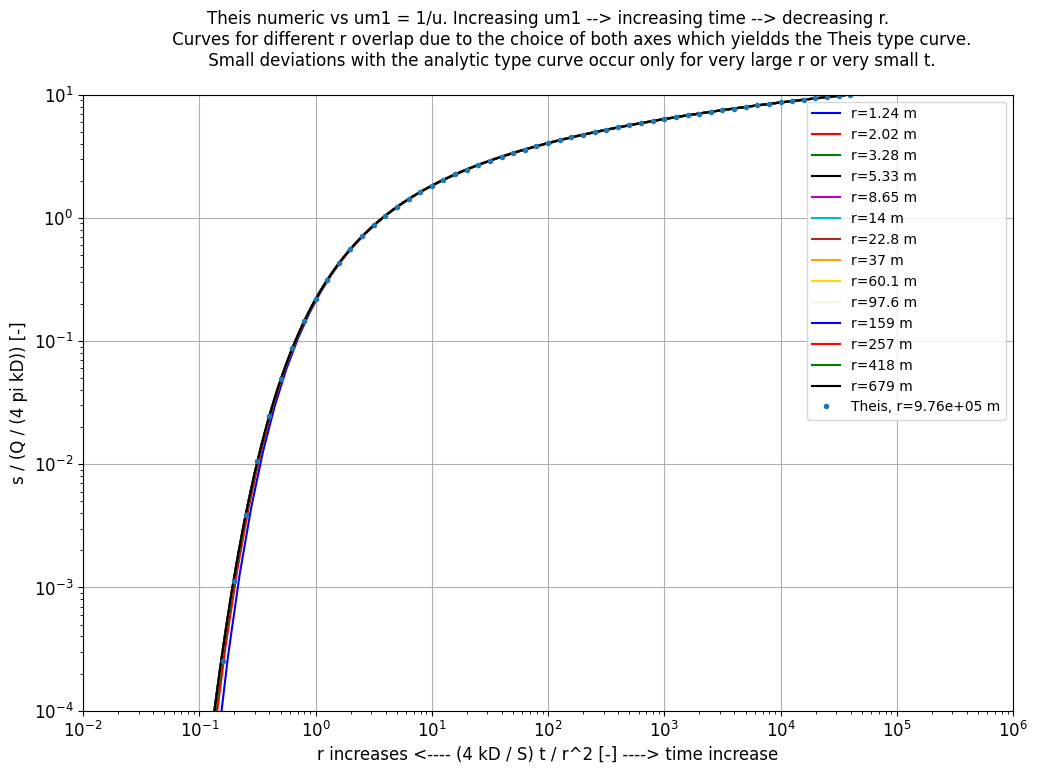

In [5]:
theis1(**theis_kwargs)
theis_use_class(**theis_kwargs)
